In [7]:
from keras.models import Model
from keras.layers import Input, Activation, Add, AveragePooling3D
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv3D, Cropping3D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.pooling import MaxPooling3D
from keras.initializers import glorot_normal
from keras.regularizers import l2

# visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Time distributed model

In [8]:
def tdist_unet(classification=False, timesteps=1, downsample=1, droprate=0.5, reg=0.0):
    assert timesteps > 0, "timesteps must be larger than 0"
    assert timesteps <= 5, "timesteps cannot exceed 5"
    assert downsample > 0, "input downsampling factor must be 1 (none) or larger"
    if timesteps > 0:
        assert droprate is not None, "dropout rate needs to be set for RNN"
        assert droprate >= 0, "dropout rate cannot be negative"
        assert droprate <= 1, "dropout rate cannot exceed 1"

    classes = 6 if classification else 1

    # block 1
    input_1 = Input(shape=(timesteps, 1, 142, 322, 262), name="input_1")  # timesteps x channels x imgsize
    # input_1 = Input(shape=(timesteps, 1, 108, 284, 228), name="input_1")  # timesteps x channels x imgsize # original dimensions
    mpool = TimeDistributed(MaxPooling3D(pool_size=(downsample, downsample, downsample), data_format="channels_first", name="mpool3D"),
                            name="TD_mpool3D")(input_1)
    conv_1 = TimeDistributed(Conv3D(filters=6, kernel_size=(1, 5, 5), data_format="channels_first", name="conv_1"),
                             name="TD_conv_1")(mpool)
    relu_2 = TimeDistributed(Activation('relu', name="ReLU_2"), name="TD_ReLU_2")(conv_1)
    down_3 = TimeDistributed(Conv3D(filters=8, kernel_size=(1, 1, 1), strides=(2, 2, 2), data_format="channels_first", name="down_3"),
                             name="TD_down_3")(relu_2)

    # block 2
    relu_4 = TimeDistributed(Activation('relu', name="ReLU_4"), name="TD_ReLU_4")(down_3)
    conv_5 = TimeDistributed(Conv3D(filters=8, kernel_size=(1, 5, 5), data_format="channels_first", name="conv_5"),
                             name="TD_conv_5")(relu_4)
    relu_6 = TimeDistributed(Activation("relu", name="ReLU_6"), name="TD_ReLU_6")(conv_5)
    conv_7 = TimeDistributed(Conv3D(filters=8, kernel_size=(1, 5, 5), data_format="channels_first", name="conv_7"),
                             name="TD_conv_7")(relu_6)

    # skip connection 1
    crop_9 = TimeDistributed(Cropping3D(cropping=((0, 0), (4, 4), (4, 4)), data_format="channels_first", name="crop_9"),
                             name="TD_crop_9")(down_3)
    merge_8 = Add(name="merge_8")([conv_7, crop_9])

    # block 3
    relu_10 = TimeDistributed(Activation("relu", name="ReLU_10"), name="TD_ReLU_10")(merge_8)
    conv_11 = TimeDistributed(Conv3D(filters=8, kernel_size=(1, 5, 5), data_format="channels_first", name="conv_11"),
                              name="TD_conv_11")(relu_10)
    relu_12 = TimeDistributed(Activation("relu", name="ReLU_12"), name="TD_ReLU_12")(conv_11)
    conv_13 = TimeDistributed(Conv3D(filters=8, kernel_size=(1, 5, 5), data_format="channels_first", name="conv_13"),
                              name="TD_conv_13")(relu_12)

    # skip connection 2
    crop_15 = TimeDistributed(Cropping3D(cropping=((0, 0), (4, 4), (4, 4)), data_format="channels_first", name="crop_15"),
                              name="TD_crop_15")(merge_8)
    merge_14 = Add(name="merge_14")([conv_13, crop_15])

    # block 4
    relu_16 = TimeDistributed(Activation("relu", name="ReLU_16"), name="TD_ReLU_16")(merge_14)
    down_17 = TimeDistributed(Conv3D(filters=16, kernel_size=(1, 1, 1), strides=(1, 2, 2), data_format="channels_first", name="down_17"),
                              name="TD_down_17")(relu_16)
    relu_18 = TimeDistributed(Activation("relu", name="ReLU_18"), name="TD_ReLU_18")(down_17)
    conv_19 = TimeDistributed(Conv3D(filters=16, kernel_size=(1, 3, 3), data_format="channels_first", name="conv_19"),
                              name="TD_conv_19")(relu_18)
    relu_20 = TimeDistributed(Activation("relu", name="ReLU_20"), name="TD_ReLU_20")(conv_19)
    conv_21 = TimeDistributed(Conv3D(filters=16, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_21"),
                              name="TD_conv_21")(relu_20)

    # skip connection 3
    crop_23 = TimeDistributed(Cropping3D(cropping=((0, 0), (1, 1), (1, 1)), data_format="channels_first", name="crop_23"),
                              name="TD_crop_23")(down_17)
    merge_22 = Add(name="merge_22")([conv_21, crop_23])

    # block 5
    relu_24 = TimeDistributed(Activation("relu", name="ReLU_24"), name="TD_ReLU_24")(merge_22)
    conv_25 = TimeDistributed(Conv3D(filters=16, kernel_size=(1, 3, 3), data_format="channels_first", name="conv_25"),
                              name="TD_conv_25")(relu_24)
    relu_26 = TimeDistributed(Activation("relu", name="ReLU_26"), name="TD_ReLU_26")(conv_25)
    conv_27 = TimeDistributed(Conv3D(filters=16, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_27"),
                              name="TD_conv_27")(relu_26)

    # skip connection 4
    crop_29 = TimeDistributed(Cropping3D(cropping=((0, 0), (1, 1), (1, 1)), data_format="channels_first", name="crop_29"),
                              name="TD_crop_29")(merge_22)
    merge_28 = Add(name="merge_28")([conv_27, crop_29])

    # block 6
    relu_30 = TimeDistributed(Activation("relu", name="ReLU_30"), name="TD_ReLU_30")(merge_28)
    down_31 = TimeDistributed(Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 2, 2), data_format="channels_first", name="down_31"),
                              name="TD_down_31")(relu_30)
    relu_32 = TimeDistributed(Activation("relu", name="ReLU_32"), name="TD_ReLU_32")(down_31)
    conv_33 = TimeDistributed(Conv3D(filters=32, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_33"),
                              name="TD_conv_33")(relu_32)
    relu_34 = TimeDistributed(Activation("relu", name="ReLU_34"), name="TD_ReLU_34")(conv_33)
    conv_35 = TimeDistributed(Conv3D(filters=32, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_35"),
                              name="TD_conv_35")(relu_34)

    # skip connection 5
    merge_36 = Add(name="merge_36")([conv_35, down_31])

    # block 7
    relu_37 = TimeDistributed(Activation("relu", name="ReLU_37"), name="TD_ReLU_37")(merge_36)
    conv_38 = TimeDistributed(Conv3D(filters=32, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_38"),
                              name="TD_conv_38")(relu_37)
    relu_39 = TimeDistributed(Activation("relu", name="ReLU_39"), name="TD_ReLU_39")(conv_38)
    conv_40 = TimeDistributed(Conv3D(filters=32, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_40"),
                              name="TD_conv_40")(relu_39)

    # skip connection 6
    merge_41 = Add(name="merge_41")([conv_40, merge_36])

    # block 8
    relu_42 = TimeDistributed(Activation("relu", name="ReLU_42"), name="TD_ReLU_42")(merge_41)
    down_43 = TimeDistributed(AveragePooling3D(pool_size=relu_42._keras_shape[-3:], data_format="channels_first", name="down_43"),
                              name="TD_down_43")(relu_42)
    flatten_44 = TimeDistributed(Flatten(name="flatten_44"), name="TD_flatten_44")(down_43) # batch_size x timesteps x features

    if timesteps > 1:
        lstm_45 = Bidirectional(LSTM(64, return_sequences=True, name="lstm_45"), name="bidir_lstm_45")(flatten_44)
        drop_46 = Dropout(rate=droprate, seed=2, name="drop_46")(lstm_45)
        lstm_47 = Bidirectional(LSTM(32, return_sequences=True, name="lstm_47"), name="bidir_lstm_47")(drop_46)
        drop_48 = Dropout(rate=droprate, seed=2, name="drop_48")(lstm_47)
        output_49 = LSTM(classes, activation="softmax", return_sequences=False, name="lstm_49")(drop_48) # batch_size x classes

        model = Model(inputs=input_1, outputs=output_49)
    else:
        flatten_45 = Flatten(name="flatten_45")(flatten_44) # flatten temporal dimension
        dense_46 = Dense(units=32, activation="relu", kernel_regularizer=l2(reg), kernel_initializer=glorot_normal(2), name="dense_45")(flatten_45)
        drop_47 = Dropout(rate=droprate, seed=2, name="drop_46")(dense_46)
        dense_48 = Dense(units=16, activation="relu", kernel_regularizer=l2(reg), kernel_initializer=glorot_normal(2), name="dense_47")(drop_47)
        drop_49 = Dropout(rate=droprate, seed=2, name="drop_48")(dense_48)
        output_50 = Dense(units=classes, activation="softmax", kernel_regularizer=l2(reg), kernel_initializer=glorot_normal(2), name="dense_49")(drop_49) # batch_size x classes

        model = Model(inputs=input_1, outputs=output_50)

    # output_44 = TimeDistributed(Conv3D(filters=1, kernel_size=(1, 1, 1), data_format="channels_first", name="conv_44"), name="TD_conv_44")(down_43)
    # model = Model(inputs=input_1, outputs=output_44)
    return model


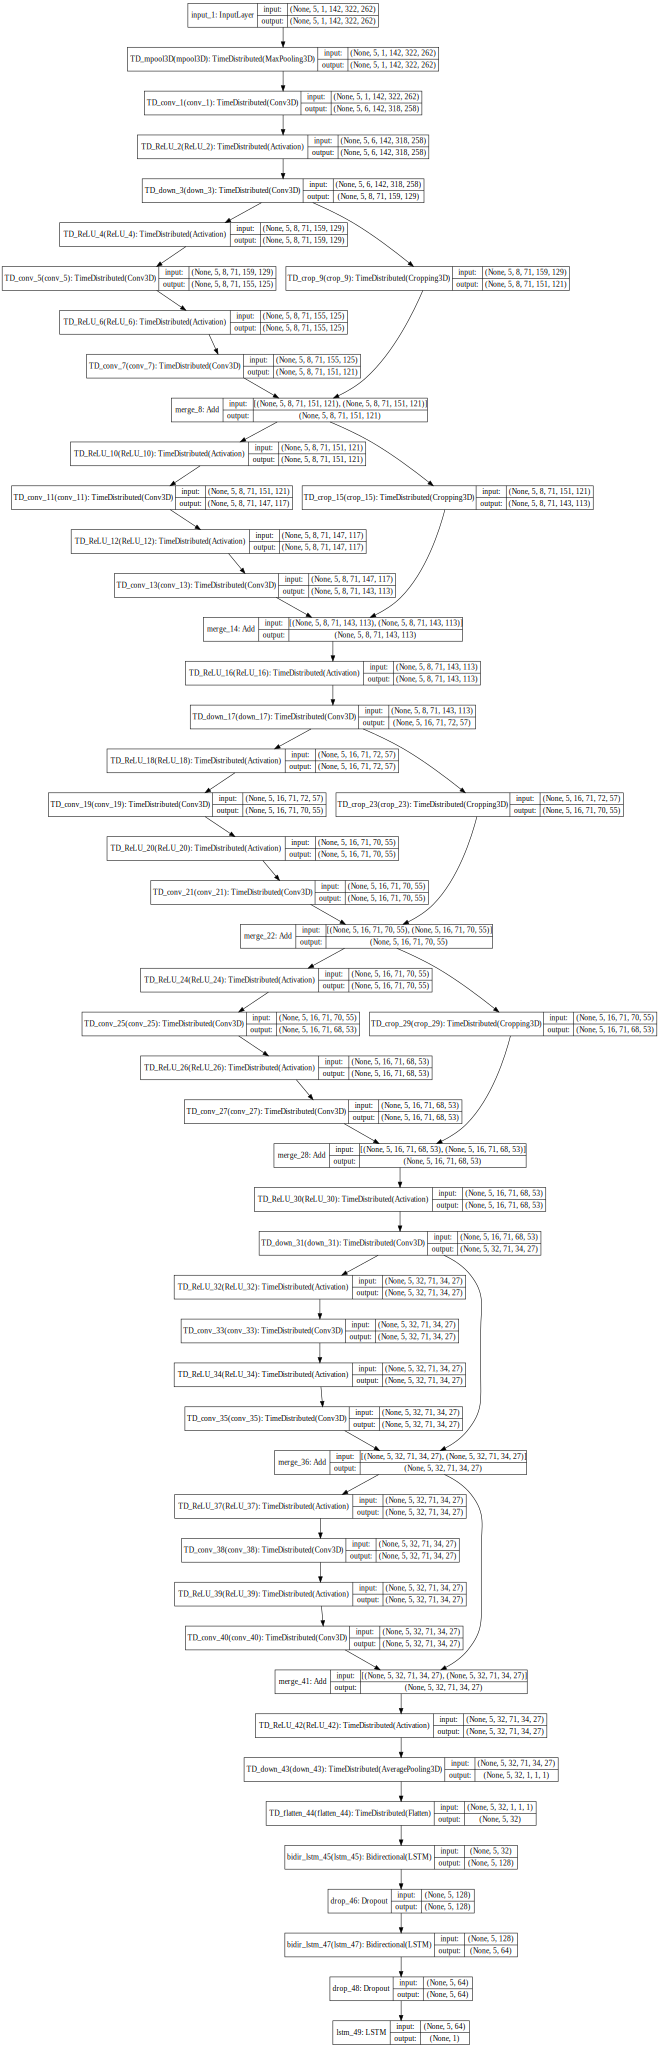

In [11]:
model = tdist_unet(timesteps=5, downsample=1, droprate=0)

# to file
# plot_model(model, to_file='model_single.png', show_shapes=True)

# to notebook
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# print(model.summary(line_length=120))

----